In [1]:
import sys
sys.path.append("..")
from utilities import *

warnings.filterwarnings("ignore")

raw_data = pd.read_excel("../data/Datos_Market_copy.xlsx")

sa = SalesAnalysis(raw_data)

/Users/oscarjimenezbou/Documents/TFG_ADE/code_prophet/TFG/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


📊 ESTADÍSTICAS DESCRIPTIVAS - VARIABLES NUMÉRICAS
        volume.sales        price
count    4306.000000  4306.000000
mean    31861.492033     2.047101
std     51654.320546     0.877312
min         0.165000     0.090000
25%      2822.145000     1.456916
50%     11254.475000     1.998394
75%     40176.807500     2.609308
max    539900.600000     7.727927


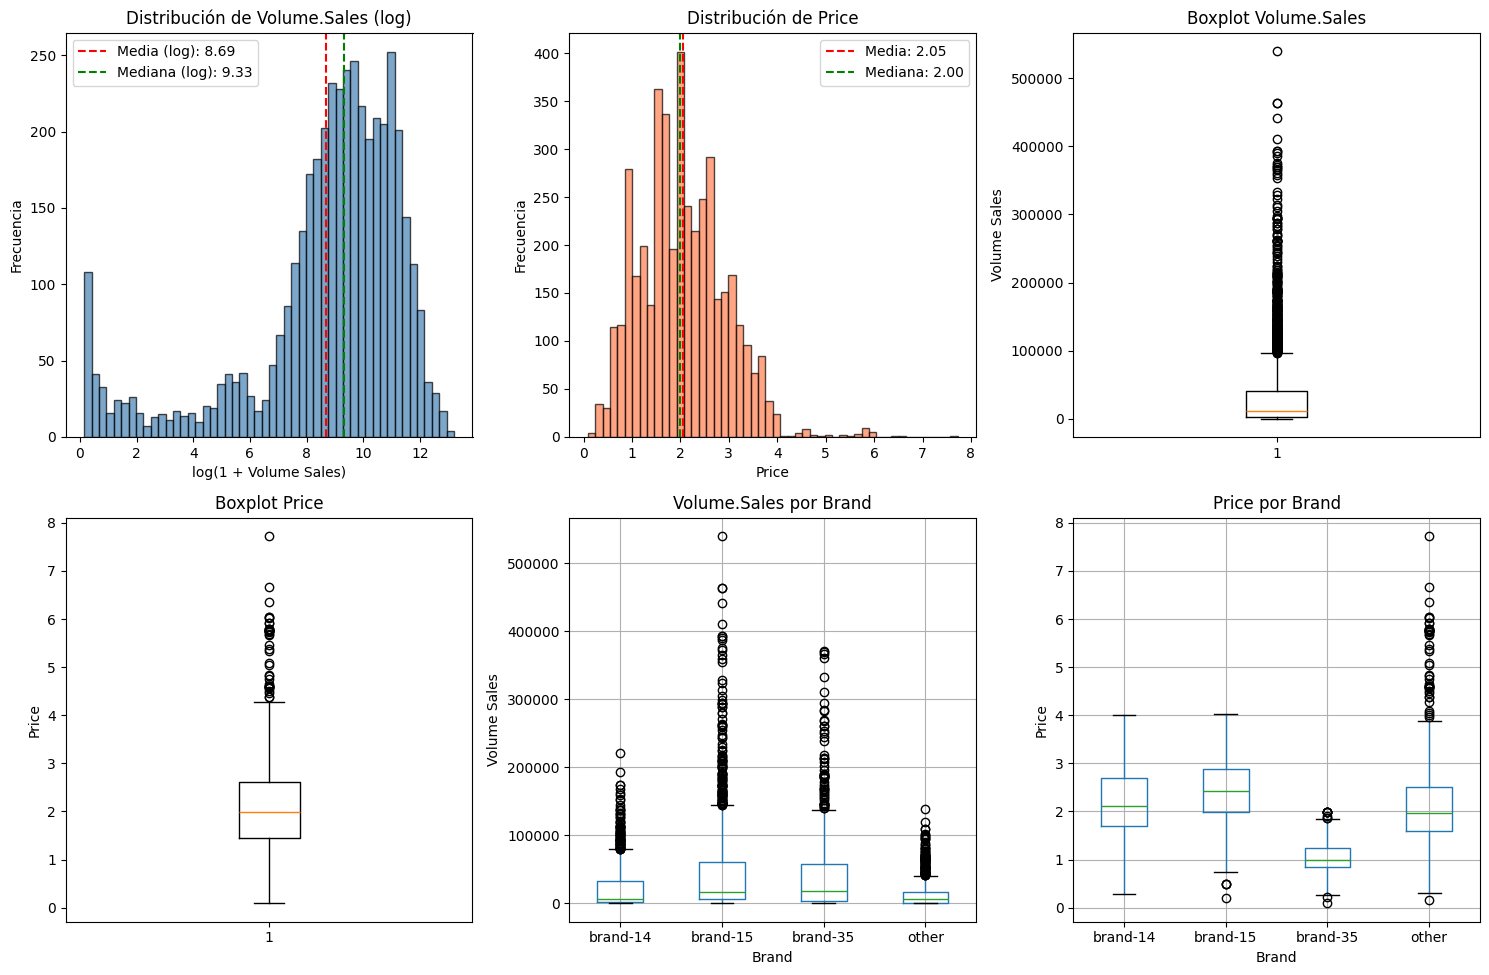


📊 DISTRIBUCIÓN POR CATEGORÍAS


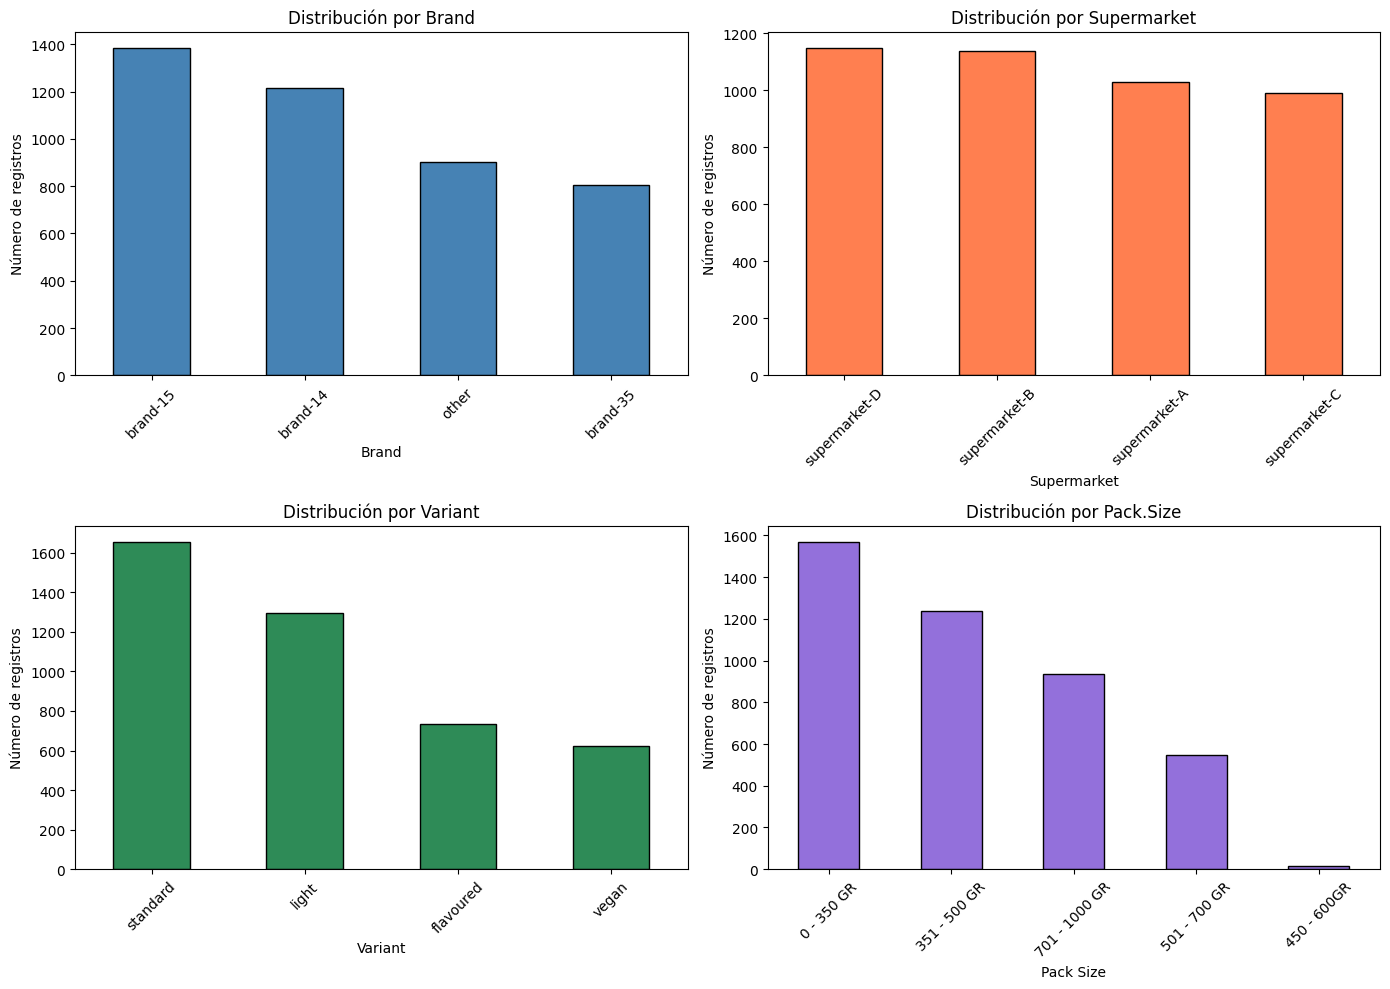


📊 CORRELACIÓN: VOLUME.SALES vs PRICE
Correlación de Pearson: 0.0319


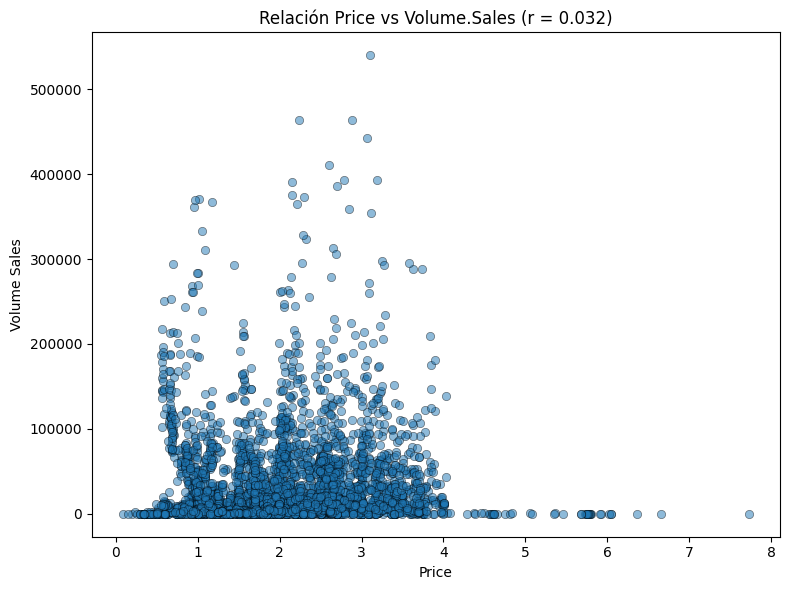

In [2]:
%run 1_preprocessing_data.ipynb

In [3]:
(
    data,
    filter_data, 
    train_data,
    test_data,
    y_train_boxcox,
    y_test_boxcox,
    boxcox_transformation_info,
) = run_preprocessing(ARIMA_model=False)


94 5 40


MODELO DE REGRESIÓN

In [6]:
model, selected_var, deleted_var = sa.regression_with_backward_elimination(train_data, verbose=True)
print(model.summary())


Fórmula del modelo:
volume_sales ~ price + C(supermarket) + C(variant) + C(pack_size) + C(brand) + (price + C(brand)) ** 2
Iteración 1: Eliminando 'C(supermarket)[T.supermarket-C]' (p-valor = 0.9789)
Iteración 2: Eliminando 'C(brand)[T.brand-15]' (p-valor = 0.4554)
Iteración 3: Eliminando 'price:C(brand)[T.other]' (p-valor = 0.3833)
Iteración 4: Eliminando 'C(brand)[T.other]' (p-valor = 0.4051)
Iteración 5: Todas las variables restantes son significativas (p-valor ≤ 0.05)

Resumen:
  Variables iniciales: 17
  Variables seleccionadas: 13
  Variables eliminadas: 4
  R² ajustado: 0.4793
                            OLS Regression Results                            
Dep. Variable:           volume_sales   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     204.7
Date:                Fri, 30 Jan 2026   Prob (F-statistic):               0.00
Time:         

In [8]:
x_train_exogs = sa.x_train_exog_custom(train_data, selected_var, model)
if False:
    print(f"\nShape de X_train_exox: {x_train_exogs.shape}")
    print("Columnas:")
    for col in x_train_exogs.columns:
        print(col)

✅ YES - All features match perfectly!


ARIMAX

In [19]:
y_train_log = np.log1p(train_data["volume.sales"])

autoarimax_model = auto_arima(
    y=y_train_log,
    X=x_train_exogs,  
    start_p=0,
    d=None,  
    start_q=0,
    max_p=3,  
    max_q=3,
    start_P=0,
    D=None, 
    start_Q=0,
    max_P=2, 
    max_Q=2,
    m=12,
    seasonal=True,
    trace=True,
    error_action="warn",
    suppress_warnings=True,
    stepwise=True,  
    n_fits=50,  
    information_criterion='aic', 
)
 
print(autoarimax_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8549.631, Time=0.23 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7802.843, Time=25.02 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6774.966, Time=75.51 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8547.631, Time=0.95 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=4.87 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=87.44 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=inf, Time=110.62 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=60.99 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=6777.623, Time=114.64 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=8551.331, Time=16.12 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=6775.824, Time=66.69 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=6778.144, Time=65.60 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=7802.837, Time=35.27 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=79.45 sec
 ARIMA(0,1,1)(0,0,1)[12]       


----------------- Residuals White Noise Test (Box-Cox) -----------------
[Heteroscedasticity Test] ARCH p-value: 0.15286069219799706 -- range(> 0.05)
[Normality Test] Jarque-Bera p-value: 0.0 -- range(> 0.05)
[Normality Test] Shapiro-Wilk p-value: 8.265168864177852e-22 -- range(> 0.05)
[Autocorrelation Test] Ljung-Box p-value:
       lb_stat  lb_pvalue
10  14.172912    0.16525 -- range(> 0.05)
[Autocorrelation Test first order] Durbin-Watson statistic: 1.9409805644405955 -- range(2.0)
-----------------------------------------------------------------------


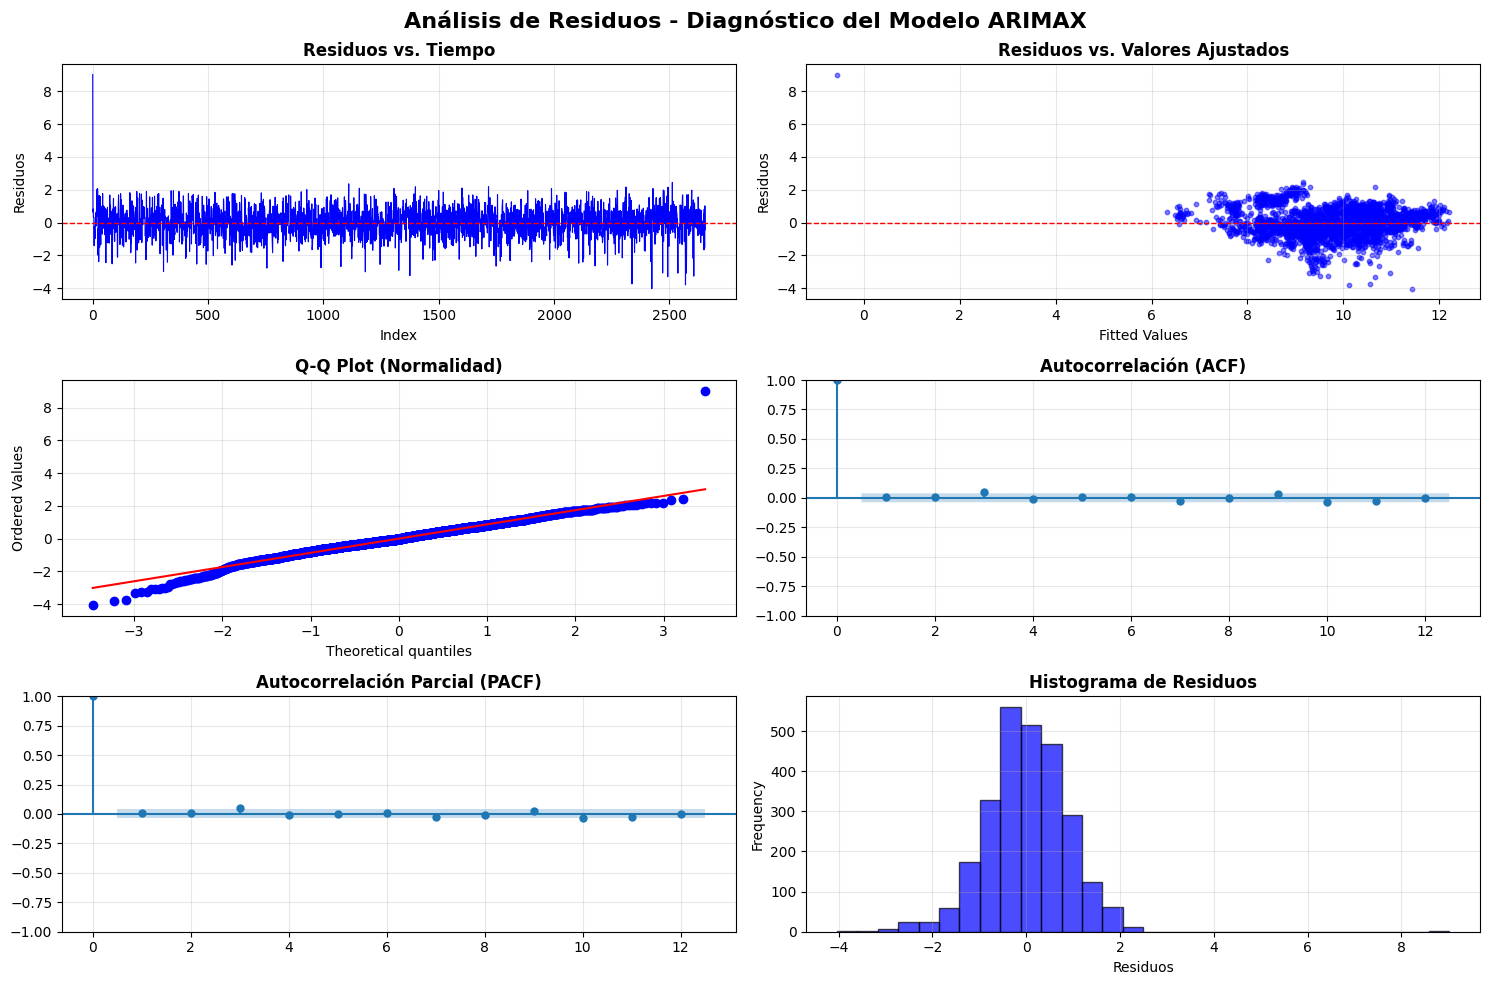

In [20]:

#  RESIDUOS
residuals = autoarimax_model.resid()
print("\n----------------- Residuals White Noise Test (Box-Cox) -----------------")
sa.residual_white_noise_test(residuals)
print("-----------------------------------------------------------------------")

# DIAGNÓSTICO DE RESIDUOS 
residuals_boxcox = autoarimax_model.arima_res_.resid
fitted_values_boxcox = autoarimax_model.arima_res_.fittedvalues
sa.analysis_residuals(residuals_boxcox, fitted_values_boxcox)